In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d
import time

from os import walk

In [2]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [309]:
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 300

### Interpolation number of points (error vs. run time)

1075 peaks found
1040 peaks found
77 matches found


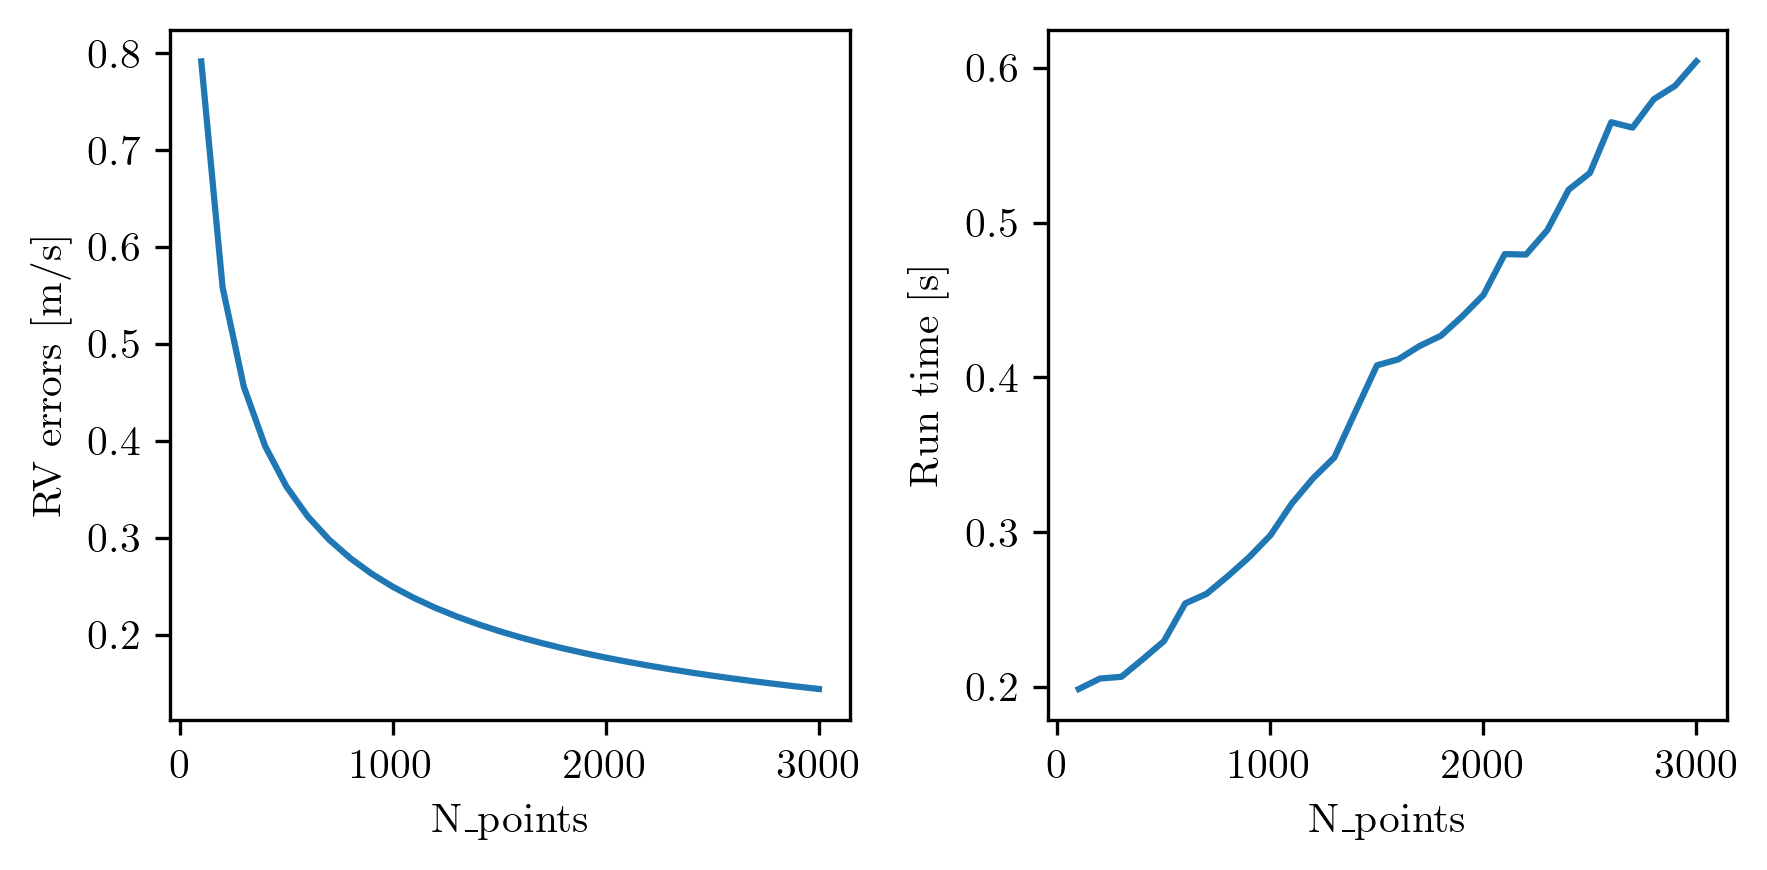

In [62]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)
file1, file2 = filenames[1], filenames[8]
matches = find_feature_matches(find_features(file1), find_features(file2))

interp_sizes = np.linspace(100, 3000, 30)
shifts_list = []
run_times = []
for s in interp_sizes:
    start = time.time()
    shifts = compute_all_feature_shifts(matches, plot=False, interp_size=int(s))
    run_times.append(time.time() - start) # in seconds
    shifts = filter_z_test(shifts)
    shifts_list.append(shifts)
    # plot_features_shift(shifts)

shifts_list = np.asarray(shifts_list)

err_mean = []
for r in shifts_list:
    shift_mean, shift_mean_err = weighted_mean(r[:, 0], r[:, 1])
    err_mean.append(shift_mean_err)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))

ax1.plot(interp_sizes, err_mean)
ax1.set_xlabel("N_points")
ax1.set_ylabel("RV errors [m/s]")

ax2.plot(interp_sizes, run_times)
ax2.set_xlabel("N_points")
ax2.set_ylabel("Run time [s]")

fig.tight_layout()

# fig.savefig("err_vs_run_time.pdf", bbox_inches="tight", dpi=300)


### Fit straight line instead of mean

In [40]:

filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_51PEG)
file1, file2 = filenames[1], filenames[8]
matches = find_feature_matches(find_features(file1), find_features(file2))
shifts = compute_all_feature_shifts(matches, plot=False, fix_errors=True)


2888 peaks found
2824 peaks found
101 matches found
0 / 101 fits failed


In [9]:
def fit_straight_line(x, y, y_err, init_value, plot=True):
    
    if plot:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.errorbar(x, y, yerr=y_err, fmt=".", color="k")

    # Fitting functions:
    def func(x, a) :
        return a + x * 0 # have to include x for numpy to work....

    # ChiSquare fit model:
    def model_chi(a) :
        y_fit = func(x, a)
        chi2 = np.sum(((y - y_fit) / y_err)**2)
        return chi2
    model_chi.errordef = 1

    minuit = Minuit(model_chi, a=init_value)
    m = minuit.migrad()        

    a, a_err = minuit.values['a'], minuit.errors['a']

    # Plot result
    if plot:
        xPeak = np.linspace(x[0], x[-1], 100)
        ax.plot(xPeak, func(xPeak, *minuit.values[:]), '-r')
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        Npoints = len(x)
        Nvar = 1                                        # Number of variables
        Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
        Chi2_fit = minuit.fval                          # The chi2 value
        Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

        d = {'a':   [a, a_err],
            'Chi2':     Chi2_fit,
            'ndf':      Ndof_fit,
            'Prob':     Prob_fit,
            'f(x)=':    "a"
        }

        text = nice_string_output(d, extra_spacing=2, decimals=5)
        add_text_to_ax(0.62, 0.95, text, ax, fontsize=14, color='r')
    
    return a, m


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.563e+07                  │              Nfcn = 13               │
│ EDM = 1.25e-12 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -35.41   │   0.34    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     a │
├───┼───────┤
│ a │ 0.117 │
└───┴───────┘

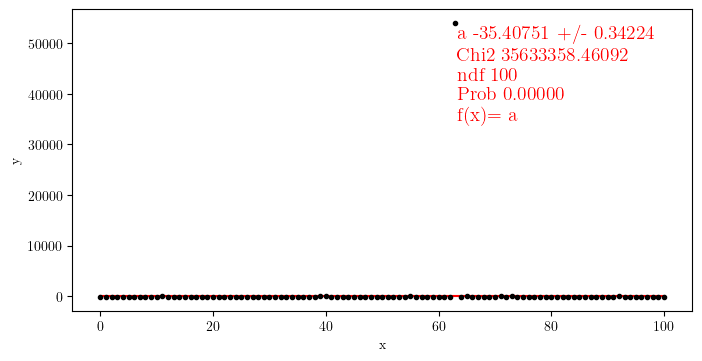

In [41]:
y, y_err = shifts[:, 0], shifts[:, 1]
c = 299792458
y, y_err = y * c, y_err * c

x = np.arange(len(y))
a, m = fit_straight_line(x, y, y_err, np.mean(y), plot=True)
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8028                       │              Nfcn = 13               │
│ EDM = 2.43e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  -112.59  │   0.34    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────┐
│   │     a │
├───┼───────┤
│ a │ 0.117 │
└───┴───────┘

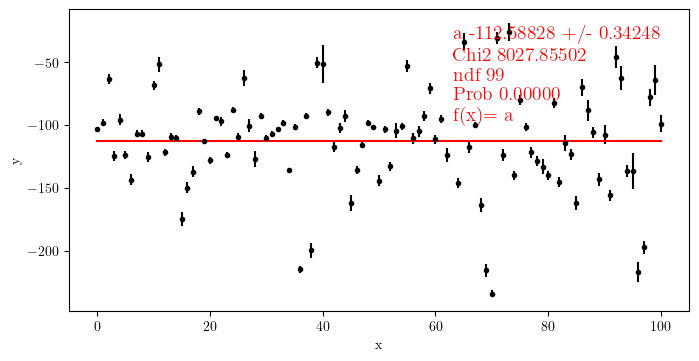

In [11]:
a, m = fit_straight_line(x[y < 20000], y[y < 20000], y_err[y < 20000], np.mean(y[y < 20000]), plot=True)
m

### Ztest

How many points does the z-test remove:


In [192]:
result, coords = np.load(RV_RESULTS_PATH + "all_features_34411_ms_bary.npy", allow_pickle=True)

T, T_rem = [], []
for r in result:
    mask = compute_z_test_mask(r[:, 0], 5)
    total = len(mask)
    total_removed = len(mask[mask == False])
    T.append(total)
    T_rem.append(total_removed)


print(f"Removed {np.sum(T_rem)} out of {np.sum(T)}, that is, {(np.sum(T_rem)/np.sum(T) * 100):.2} %")


Removed 4531 out of 401293, that is, 1.1 %


### Interpolating only one of the features

In [286]:
def compute_all_feature_shifts2(matches, log=True, plot=False, ax=[], interp_size = 1000, return_extra=False, return_df=False):
    """ Calls compute_feature_shift for a list of matches """

    shifts = []
    # for k in tqdm(np.arange(len(matches))):
    for k in np.arange(len(matches)):
        f1 = matches[k][0]
        f2 = matches[k][1]

        x1      = f1[0]
        y1      = f1[1]
        y1_err  = f1[2]
        peak1   = f1[3]
        x2      = f2[0]
        y2      = f2[1]
        peak2   = f2[3]

        if len(ax) == 0:
            shifts.append(compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2, plot=plot, interp_size = interp_size, return_df=return_df, return_extra=return_extra))
        else:
            shifts.append(compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2, plot=plot, ax=ax[k], interp_size = interp_size, return_df=return_df, return_extra=return_extra))


    shifts = np.asarray(shifts, dtype=object)
    if log:
        failed_n = len(shifts[:, 2][shifts[:, 2] == 0])
        if failed_n > 0: # only print if some fits failed
            print(f"{failed_n} / {len(shifts)} fits failed")
    return shifts


def compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2, plot=False, ax=None, return_df=False, interp_size = 1000, return_extra=False):
    """ Attempts to fit two features with based on a shift parameter.
        Returns shift_min_final (m/s), shift_min_final_err (m/s), valid 
        """
    
    c = 299792458 # m/s
    # G = 6.67e-11 # N m^2 / kg^2
    # M_sun = 2e30
    # R_sun = 696340000
    # M_star = 1.08 * M_sun # kg
    # R_star = 1.28 * R_sun
    # G_pot = G*M_star/R_star

    # Interp first file
    f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")

    # ChiSquare fit model:
    def model_chi2(A):

        # Interpolate template
        # interp_x2 = x2 * (1 + A/c)/(1 - G_pot/c**2 ) # GR
        interp_x2 = x2 * (1 + A/c) # Wavelengths are be stretched by a factor of (1 + v/c)
        f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

        # Find common x-range
        intercept_mask = (x1 > min(interp_x2)) & (x1 < max(interp_x2))
        x1_intercept = x1[intercept_mask]
        y1_intercept = y1[intercept_mask]
        y1_err_intercept = y1_err[intercept_mask]
        
        # Evaluate interpolation
        ynew2 = f2(x1_intercept)
    
        # Compute chi2
        chi2 = np.sum(((y1_intercept - ynew2) / y1_err_intercept)**2)
        return chi2
    model_chi2.errordef = 1
        
    # Init value
    # A_init = (peak2 / peak1 - 1 ) * c # shift between the two peaks
    A_init = (peak1 / peak2 - 1 ) * c # shift between the two peaks

    # Compute bounds on A
    x1_min, x1_max = min(x1), max(x1)
    A_lower_bound = (x1_min / peak2 - 1 ) * c
    A_upper_bound = (x1_max / peak2 - 1 ) * c

    minuit = Minuit(model_chi2, A=A_init)
    minuit.limits["A"] = (A_lower_bound, A_upper_bound)
    minuit.migrad()
    
    # Results
    valid = minuit.valid
    shift_min_final = minuit.values['A']
    shift_min_final_err = minuit.errors['A']
    forced = minuit.fmin.has_made_posdef_covar
    at_limit = minuit.fmin.has_parameters_at_limit

    if forced or at_limit:
        valid = False

    
    # Compute ndof for the final fit
    interp_x2 = x2 * (1 + shift_min_final/c)
    intercept_mask = (x1 > min(interp_x2)) & (x1 < max(interp_x2))
    ndof = len(intercept_mask) - 1

    # Plot final shifted values
    if plot:

        if ax == None:
            fig, ax = plt.subplots(figsize=(14,6))

        ax.plot(x1, y1)
        ax.plot(x2 * (1 + shift_min_final/c), y2)

        if not valid:
            ax.set_facecolor('pink')


    if return_df:
        return pd.DataFrame({
            'shift':    [shift_min_final],
            'err':    [shift_min_final_err],
            'valid': [valid],
            })
    elif return_extra:

        # Interpolate and return the peak wavelength (should be better than nearest pixel)
        f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
        f2 = interp1d(x2, y2, kind='cubic', fill_value="extrapolate")
        new_x1 = np.linspace(min(x1), max(x1), 1000)
        new_x2 = np.linspace(min(x2), max(x2), 1000)
        interp_y1 = f1(new_x1)
        interp_y2 = f2(new_x2)
        new_peak1_wavel = new_x1[np.argmax(interp_y1)]
        new_peak2_wavel = new_x2[np.argmax(interp_y2)]

        return shift_min_final, shift_min_final_err, valid, minuit.fval, ndof, new_peak1_wavel, new_peak2_wavel
    else:
        return shift_min_final, shift_min_final_err, valid#, minuit


In [235]:
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)

shifts_list_1000_2 = []
error_scale = np.sqrt(2)

f1 = find_features(filenames[0], custom_error_scale=error_scale)
for i in np.arange(1, 10):
    f2 = find_features(filenames[i], custom_error_scale=error_scale)
    matches = find_feature_matches2(f1, f2)
    shifts = compute_all_feature_shifts(matches, return_extra=True)
    shifts_list_1000_2.append(shifts)
shifts_list_1000_2 = np.concatenate(shifts_list_1000_2)

1267 peaks found
1255 peaks found
811 matches found
Rejected 21 proposed matches
Rejected 434 proposed matches based on area
1219 peaks found
797 matches found
Rejected 43 proposed matches
Rejected 426 proposed matches based on area
1250 peaks found
795 matches found
Rejected 21 proposed matches
Rejected 451 proposed matches based on area
1265 peaks found
760 matches found
Rejected 16 proposed matches
Rejected 491 proposed matches based on area
1240 peaks found
750 matches found
Rejected 43 proposed matches
Rejected 473 proposed matches based on area
1234 peaks found
794 matches found
Rejected 39 proposed matches
Rejected 433 proposed matches based on area
1210 peaks found
775 matches found
Rejected 55 proposed matches
Rejected 435 proposed matches based on area
1208 peaks found
752 matches found
Rejected 61 proposed matches
Rejected 453 proposed matches based on area
1269 peaks found
776 matches found
Rejected 12 proposed matches
Rejected 478 proposed matches based on area


Text(0, 0.5, 'Count')

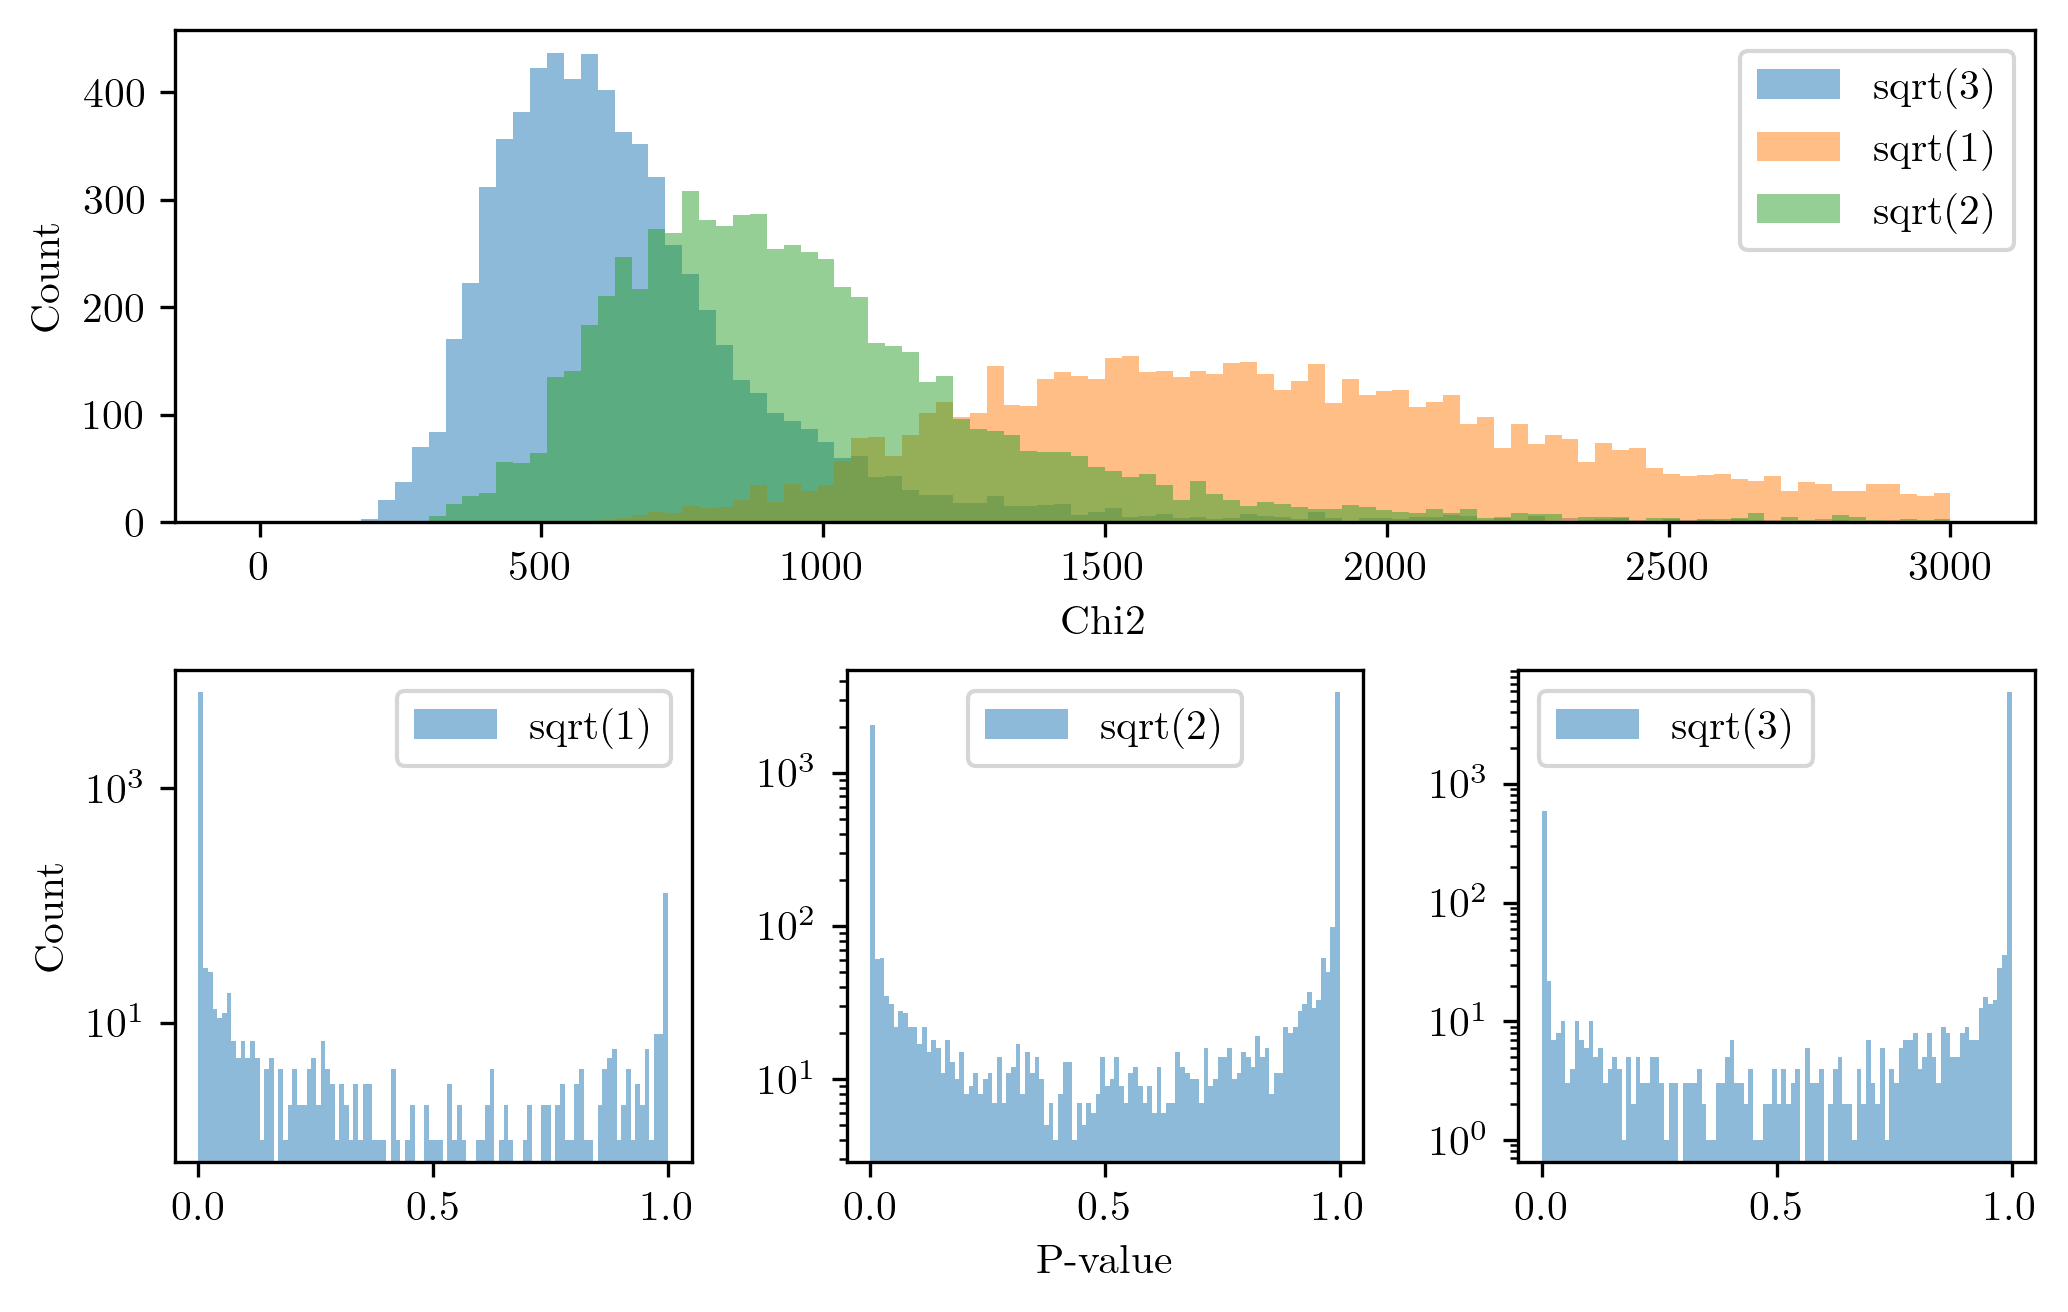

In [248]:
plt.figure(figsize = (8, 5))
grid = plt.GridSpec(2, 3, wspace=0.3, hspace=0.3)
ax1 = plt.subplot(grid[0, :3])  # wide top plot
ax2 = plt.subplot(grid[1, 0])   # |
ax3 = plt.subplot(grid[1, 1])   # | Three cols on the second row
ax4 = plt.subplot(grid[1, 2])   # |

df1000_3 = pd.DataFrame(shifts_list_3_1000)
df1000_3.columns = ["rv", "err", "valid", "chi2", "λ1", "λ2"]
ax1.hist(df1000_3.chi2, bins=100, range=(0, 3000), alpha=0.5, label="sqrt(3)");

df1000_1 = pd.DataFrame(shifts_list_1000)
df1000_1.columns = ["rv", "err", "valid", "chi2", "λ1", "λ2"]
ax1.hist(df1000_1.chi2, bins=100, range=(0, 3000), alpha=0.5, label="sqrt(1)");

df1000_2 = pd.DataFrame(shifts_list_1000_2)
df1000_2.columns = ["rv", "err", "valid", "chi2", "λ1", "λ2"]
ax1.hist(df1000_2.chi2, bins=100, range=(0, 3000), alpha=0.5, label="sqrt(2)");
ax1.legend()
ax1.set_xlabel("Chi2")
ax1.set_ylabel("Count")

prob1 = [stats.chi2.sf(chi2, 999) for chi2 in df1000_1.chi2]
prob2 = [stats.chi2.sf(chi2, 999) for chi2 in df1000_2.chi2]
prob3 = [stats.chi2.sf(chi2, 999) for chi2 in df1000_3.chi2]
ax2.hist(prob1, range=(0,1), bins=100, label="sqrt(1)", alpha=0.5);
ax3.hist(prob2, range=(0,1), bins=100, label="sqrt(2)", alpha=0.5);
ax4.hist(prob3, range=(0,1), bins=100, label="sqrt(3)", alpha=0.5);
ax2.legend()
ax3.legend()
ax4.legend()
ax2.set_yscale("log")
ax3.set_yscale("log")
ax4.set_yscale("log")
ax3.set_xlabel("P-value")
ax2.set_ylabel("Count")





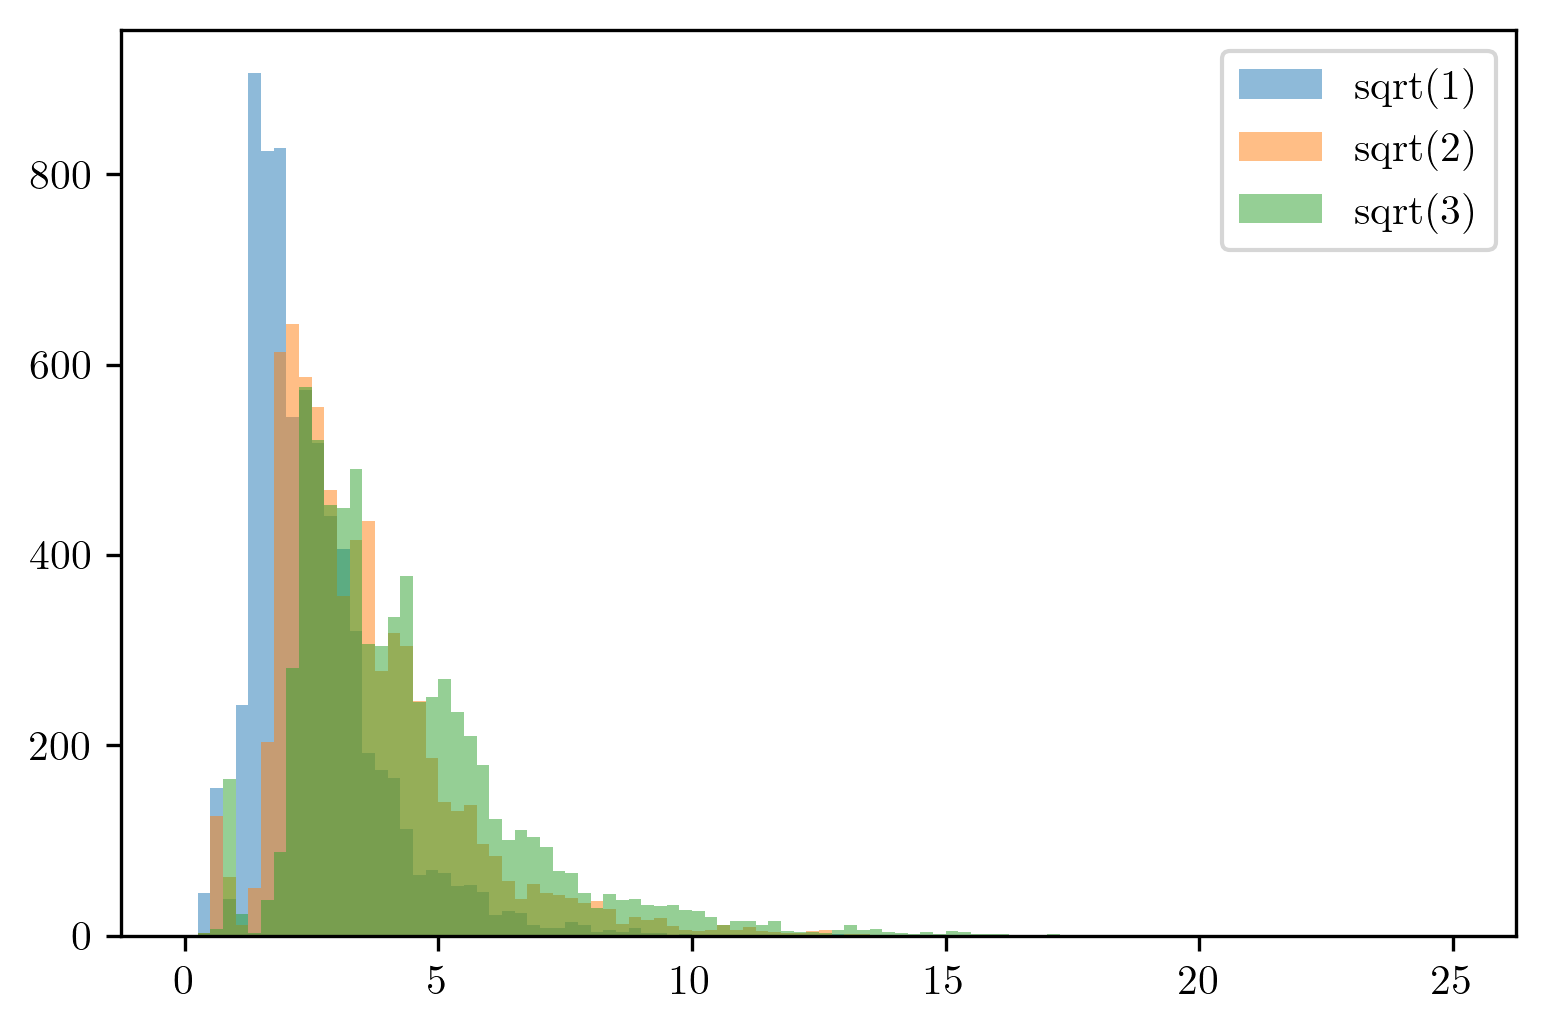

In [253]:
# e1 = df1000_1.err
# e2 = df1000_2
# e3 = df1000_3

plt.hist(df1000_1.err, bins=100, range=(0, 25), label="sqrt(1)", alpha=0.5);
plt.hist(df1000_2.err, bins=100, range=(0, 25), label="sqrt(2)", alpha=0.5);
plt.hist(df1000_3.err, bins=100, range=(0, 25), label="sqrt(3)", alpha=0.5);
plt.legend()

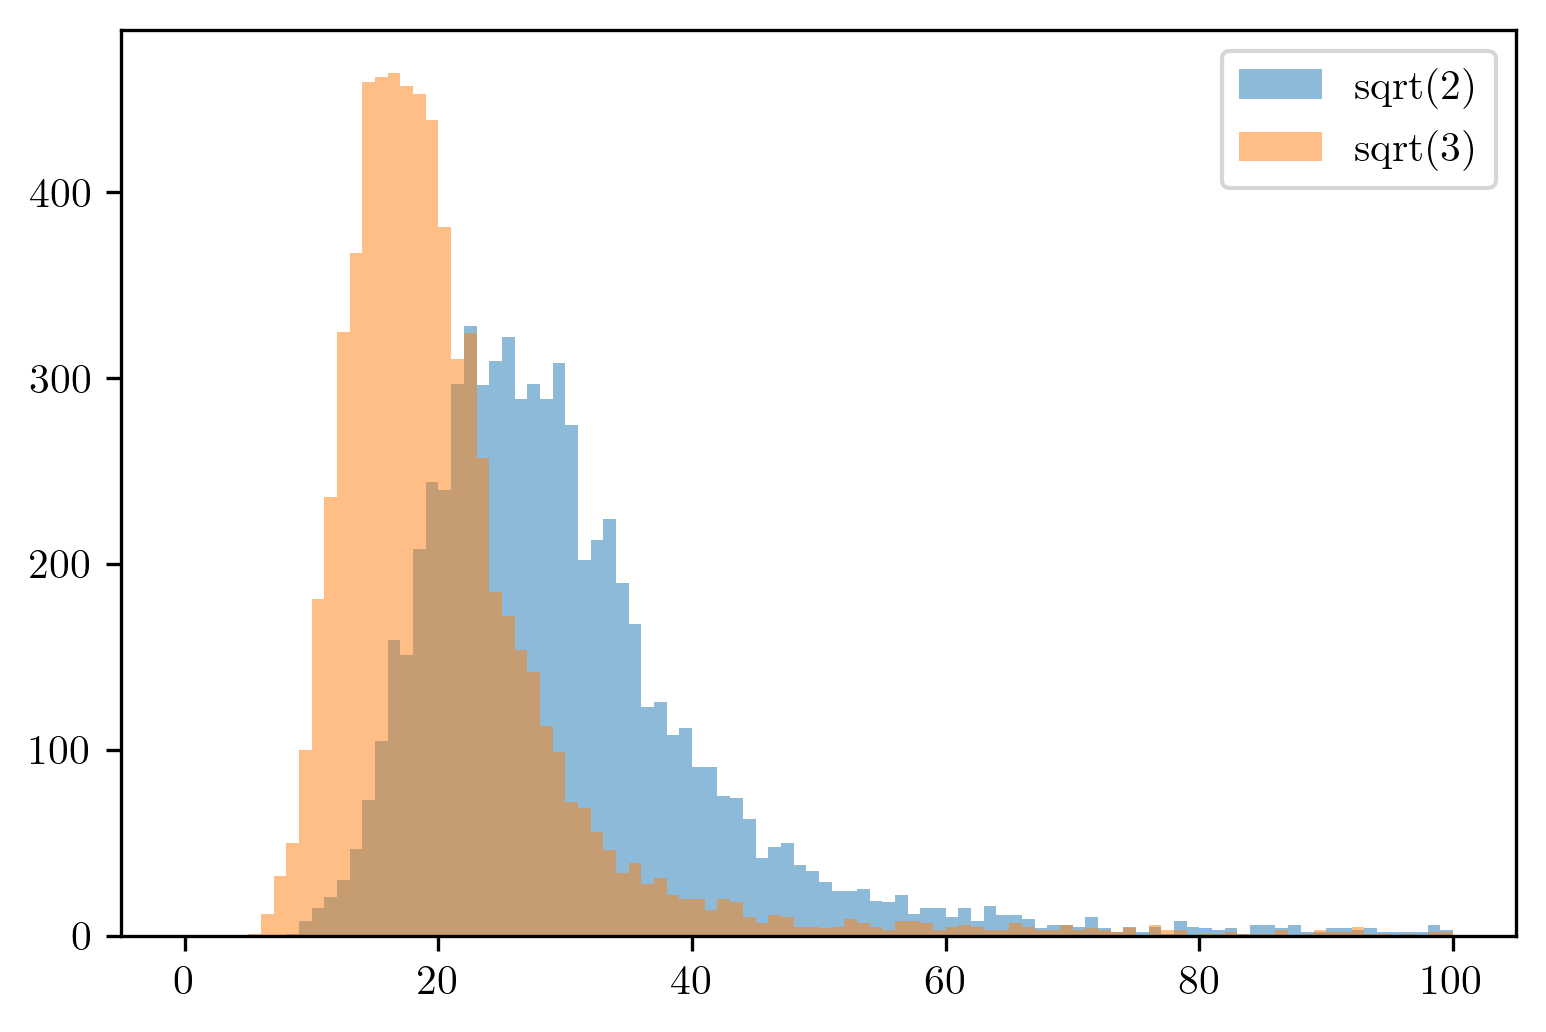

In [195]:

df = pd.DataFrame(shifts_list)
df.columns = ["rv", "err", "valid", "chi2", "ndof", "λ1", "λ2"]
plt.hist(df.chi2, bins=100, range=(0, 100), alpha=0.5, label="sqrt(2)");

df3 = pd.DataFrame(shifts_list_3)
df3.columns = ["rv", "err", "valid", "chi2", "ndof", "λ1", "λ2"]
plt.hist(df3.chi2, bins=100, range=(0, 100), alpha=0.5, label="sqrt(3)");

plt.legend()



# plt.hist(df.ndof, bins=100, range=(0, 100));

# _ = plot_features_shift(np.column_stack([df.rv, df.err, df.valid]))


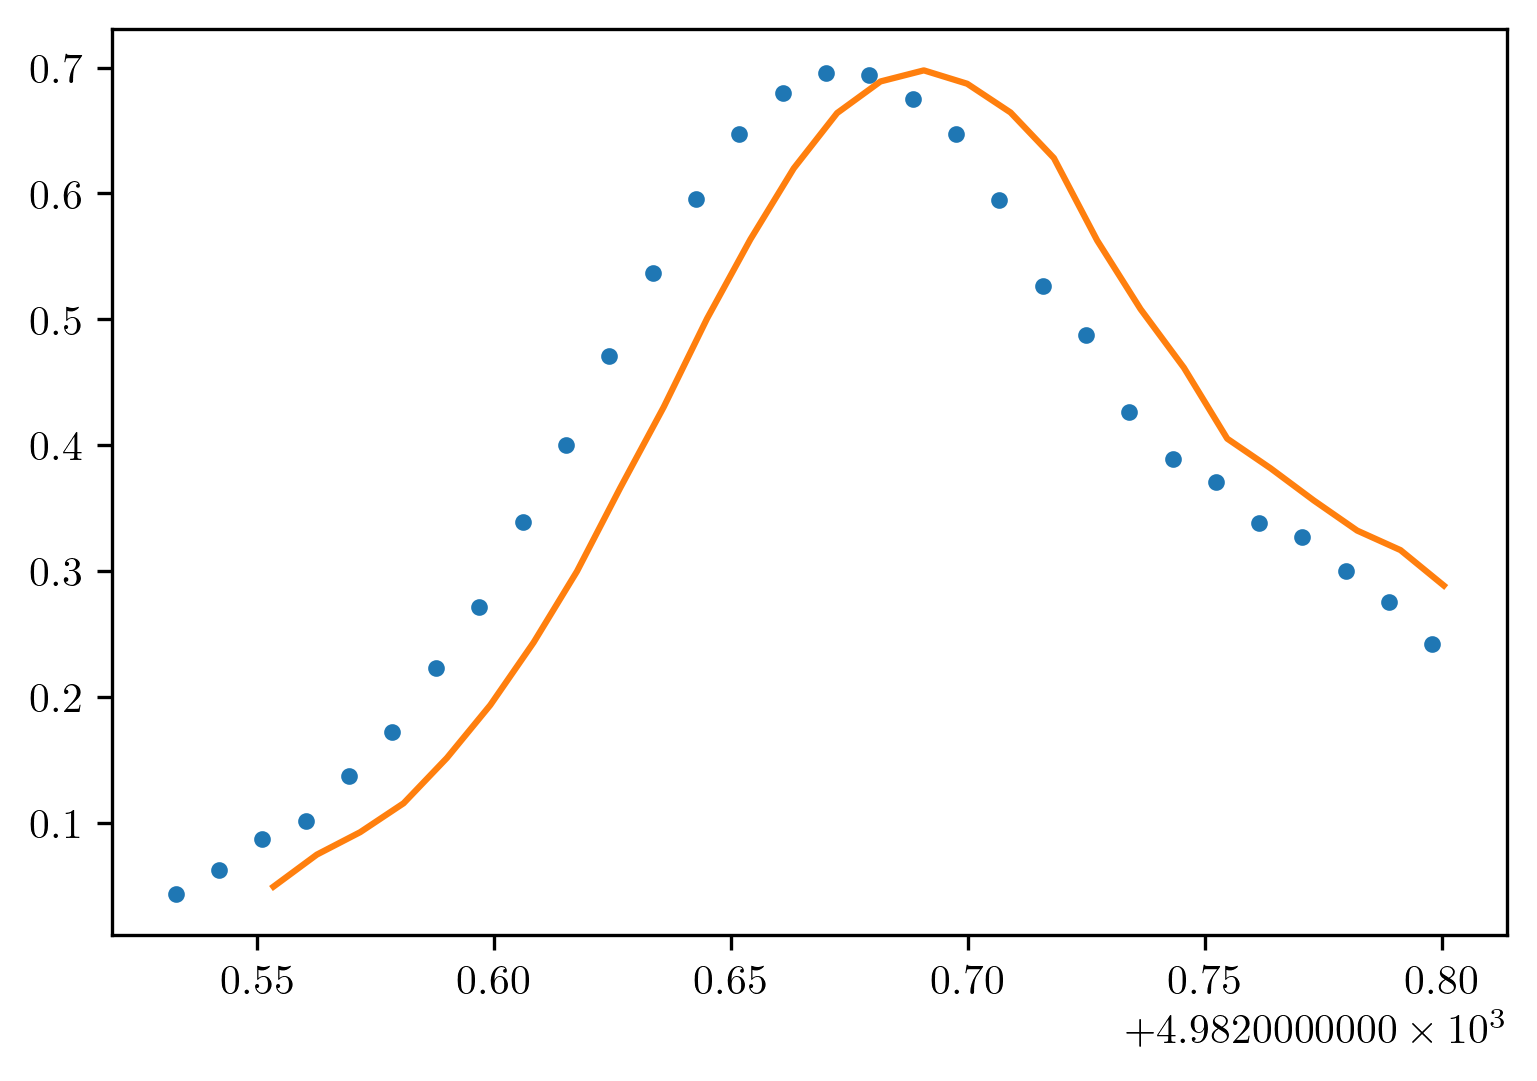

In [109]:
k = 30
f1, f2 = matches[k][0], matches[k][1]

x1      = f1[0]
y1      = f1[1]
y1_err  = f1[2]
peak1   = f1[3]
x2      = f2[0]
y2      = f2[1]
peak2   = f2[3]

# plt.plot(x1, y1, ".")
plt.plot(x2, y2, ".")


interp_x2 = x2 * (1 + 1000/c)

f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

# Find values from x1 that are within the interpoaltion range of x2
x1_intercept = x1[(x1 > min(interp_x2)) & (x1 < max(interp_x2))]

ynew = f2(x1_intercept)
plt.plot(x1_intercept, ynew)
# plt.plot(xlin, f2(xlin))


# rv, rv_err, valid, chi2, λ1, λ2 = compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2, plot=True, return_extra=True) 
# np.around([rv, rv_err, chi2], 3), len(x1)

    

In [312]:

def compute_feature_shift2_flipper(x1, y1, y1_err, peak1, x2, y2, y2_err, peak2):
    columns = ["rv", "err", "valid", "chi2", "ndof", "λ1", "λ2"]
    df1 = pd.DataFrame(compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2, return_extra=True)).T # need to transpose otherwise creates rows
    df1.columns = columns
    df2 = pd.DataFrame(compute_feature_shift2(x2, y2, y2_err, peak2, x1, y1, peak1, return_extra=True)).T
    df2.columns = columns

    rv = np.mean([df1.rv, df2.rv])
    rv_err = np.mean([df1.err, df2.err])
    # valid = (df1.valid and df2.valid).all()
    chi2 = np.mean([df1.chi2, df2.chi2])
    ndof = np.mean([df1.ndof, df2.ndof])
    λ1 = df1.λ1
    λ2 = df1.λ2

    return [rv, rv_err, True, chi2, ndof, float(df1.λ1), float(df1.λ2)]

In [313]:
k = 30
f1, f2 = matches[k][0], matches[k][1]

x1      = f1[0]
y1      = f1[1]
y1_err  = f1[2]
peak1   = f1[3]
x2      = f2[0]
y2      = f2[1]
y2_err  = f2[2]
peak2   = f2[3]

compute_feature_shift2_flipper(x1, y1, y1_err, peak1, x2, y2, y2_err, peak2)

[-2.2640045733587613,
 37.18222372333662,
 True,
 19.96783780293331,
 29.0,
 4980.151617821594,
 4980.1427936236705]

In [316]:
def compute_all_feature_shifts_flipper(matches, log=True):
    """ Calls compute_feature_shift for a list of matches """

    shifts = []
    # for k in tqdm(np.arange(len(matches))):
    for k in np.arange(len(matches)):
        f1 = matches[k][0]
        f2 = matches[k][1]

        x1      = f1[0]
        y1      = f1[1]
        y1_err  = f1[2]
        peak1   = f1[3]
        x2      = f2[0]
        y2      = f2[1]
        y2_err  = f2[2]
        peak2   = f2[3]

        shifts.append(compute_feature_shift2_flipper(x1, y1, y1_err, peak1, x2, y2, y2_err, peak2))

    shifts = np.asarray(shifts, dtype=object)
    if log:
        failed_n = len(shifts[:, 2][shifts[:, 2] == 0])
        if failed_n > 0: # only print if some fits failed
            print(f"{failed_n} / {len(shifts)} fits failed")
    return shifts


In [321]:
N_processes = 6

# Get list of files and find all features
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)[:25]
# filenames = get_all_spectra_filenames(SPECTRA_PATH_34411)

# Find features in all files 
features = []
print("Finding features for all files...")
for filename in tqdm(filenames):
    features.append(find_features(filename, log=False))


# Setup coords :: Compute one list of coords
all_coords = compute_coords(len(filenames))        
        
# Define function for each process
def compute(coords):
    x = coords[0]
    y = coords[1]
    matches = find_feature_matches2(features[x], features[y], log=False)
    shifts = compute_all_feature_shifts_flipper(matches, log=False)
    return shifts


if __name__ == '__main__':
    import multiprocess
    pool = multiprocess.Pool(processes = N_processes)

    # With progress bar
    result = []
    print("Computing shifts for all files combinations...")
    for r in tqdm(pool.imap_unordered(compute, all_coords), total=len(all_coords)):
        result.append(r)
        

    np.save(RV_RESULTS_PATH + "flipper", [result, all_coords])
    print("Finished!")


25 24


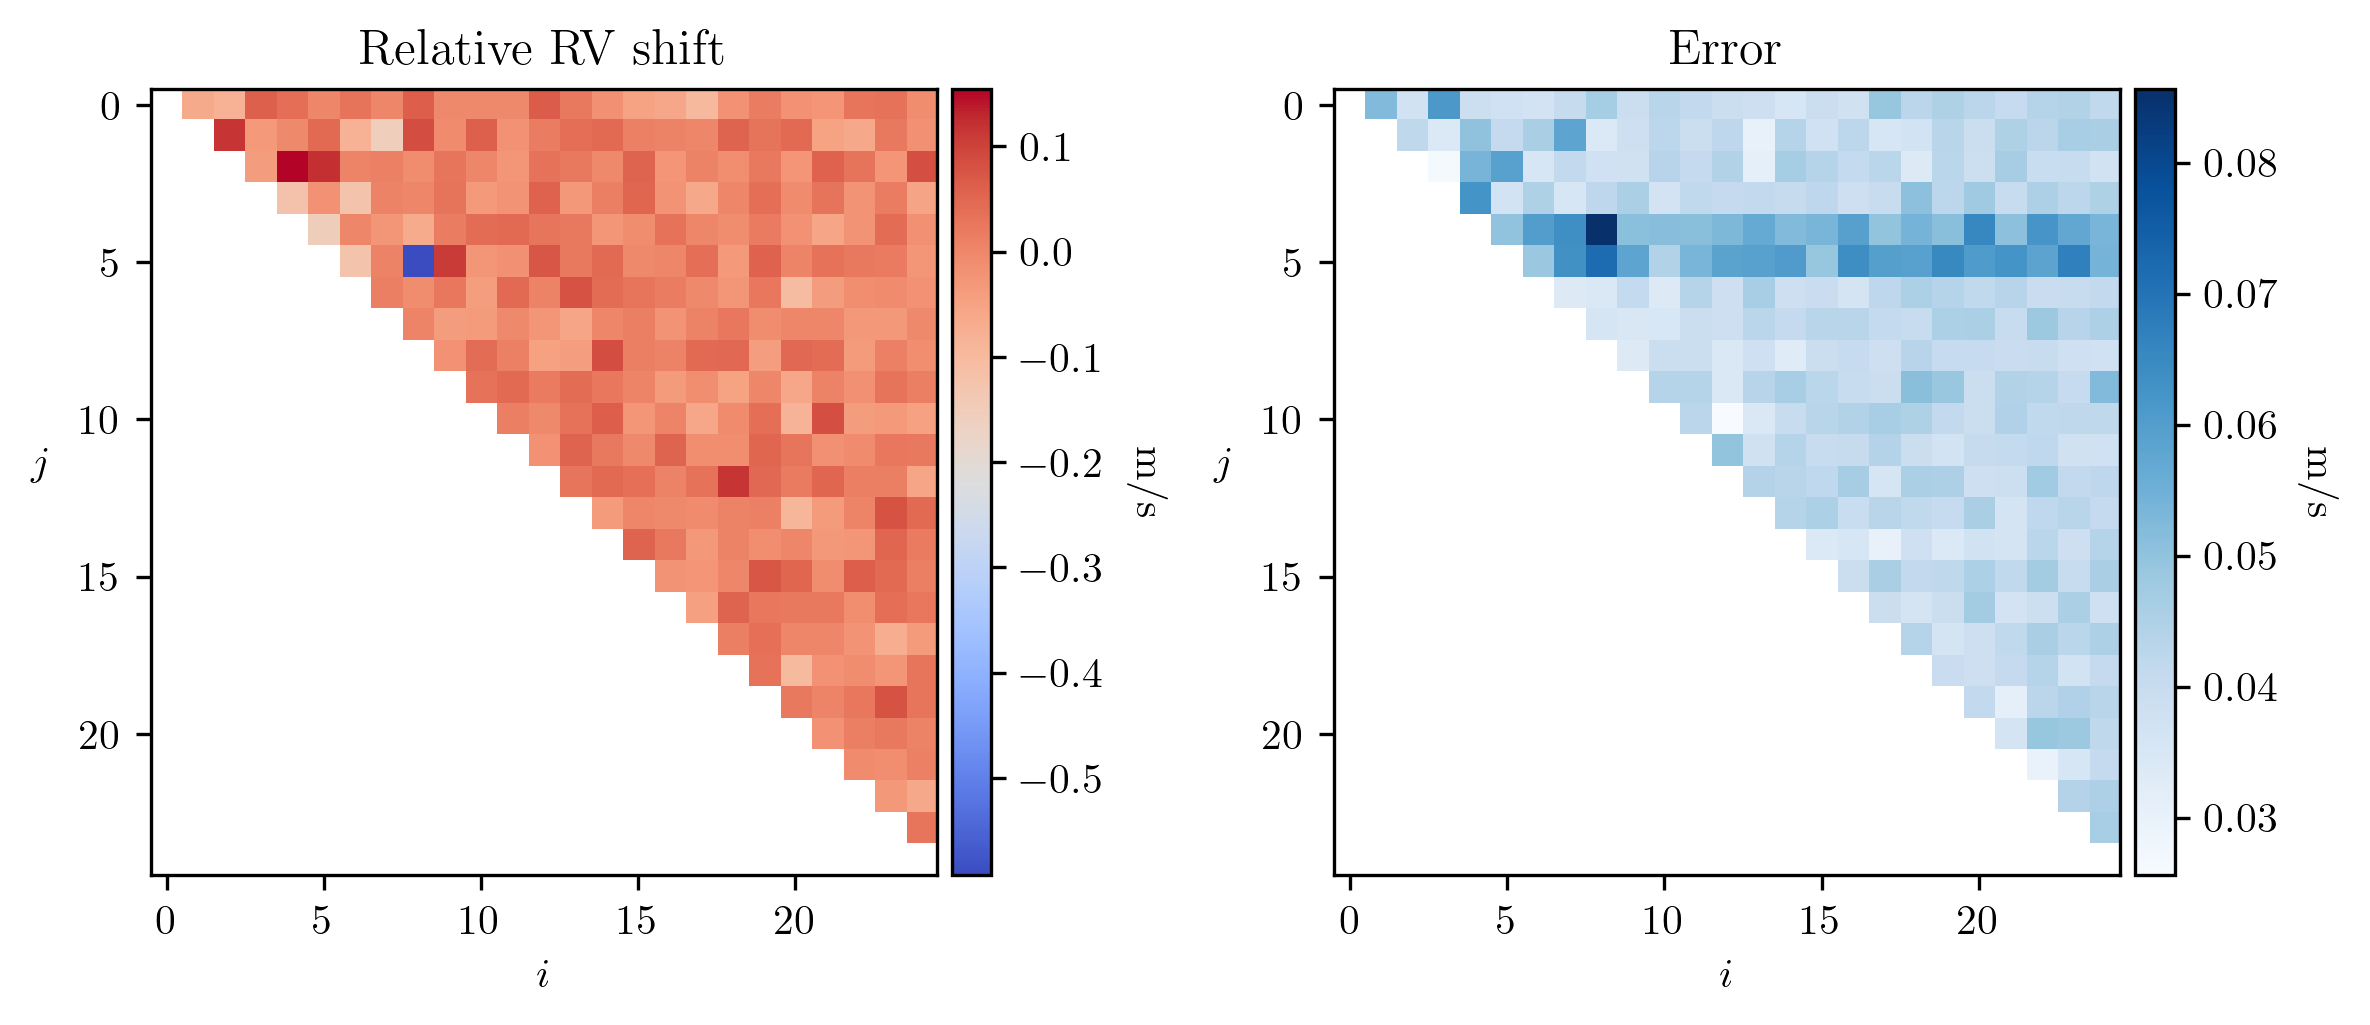

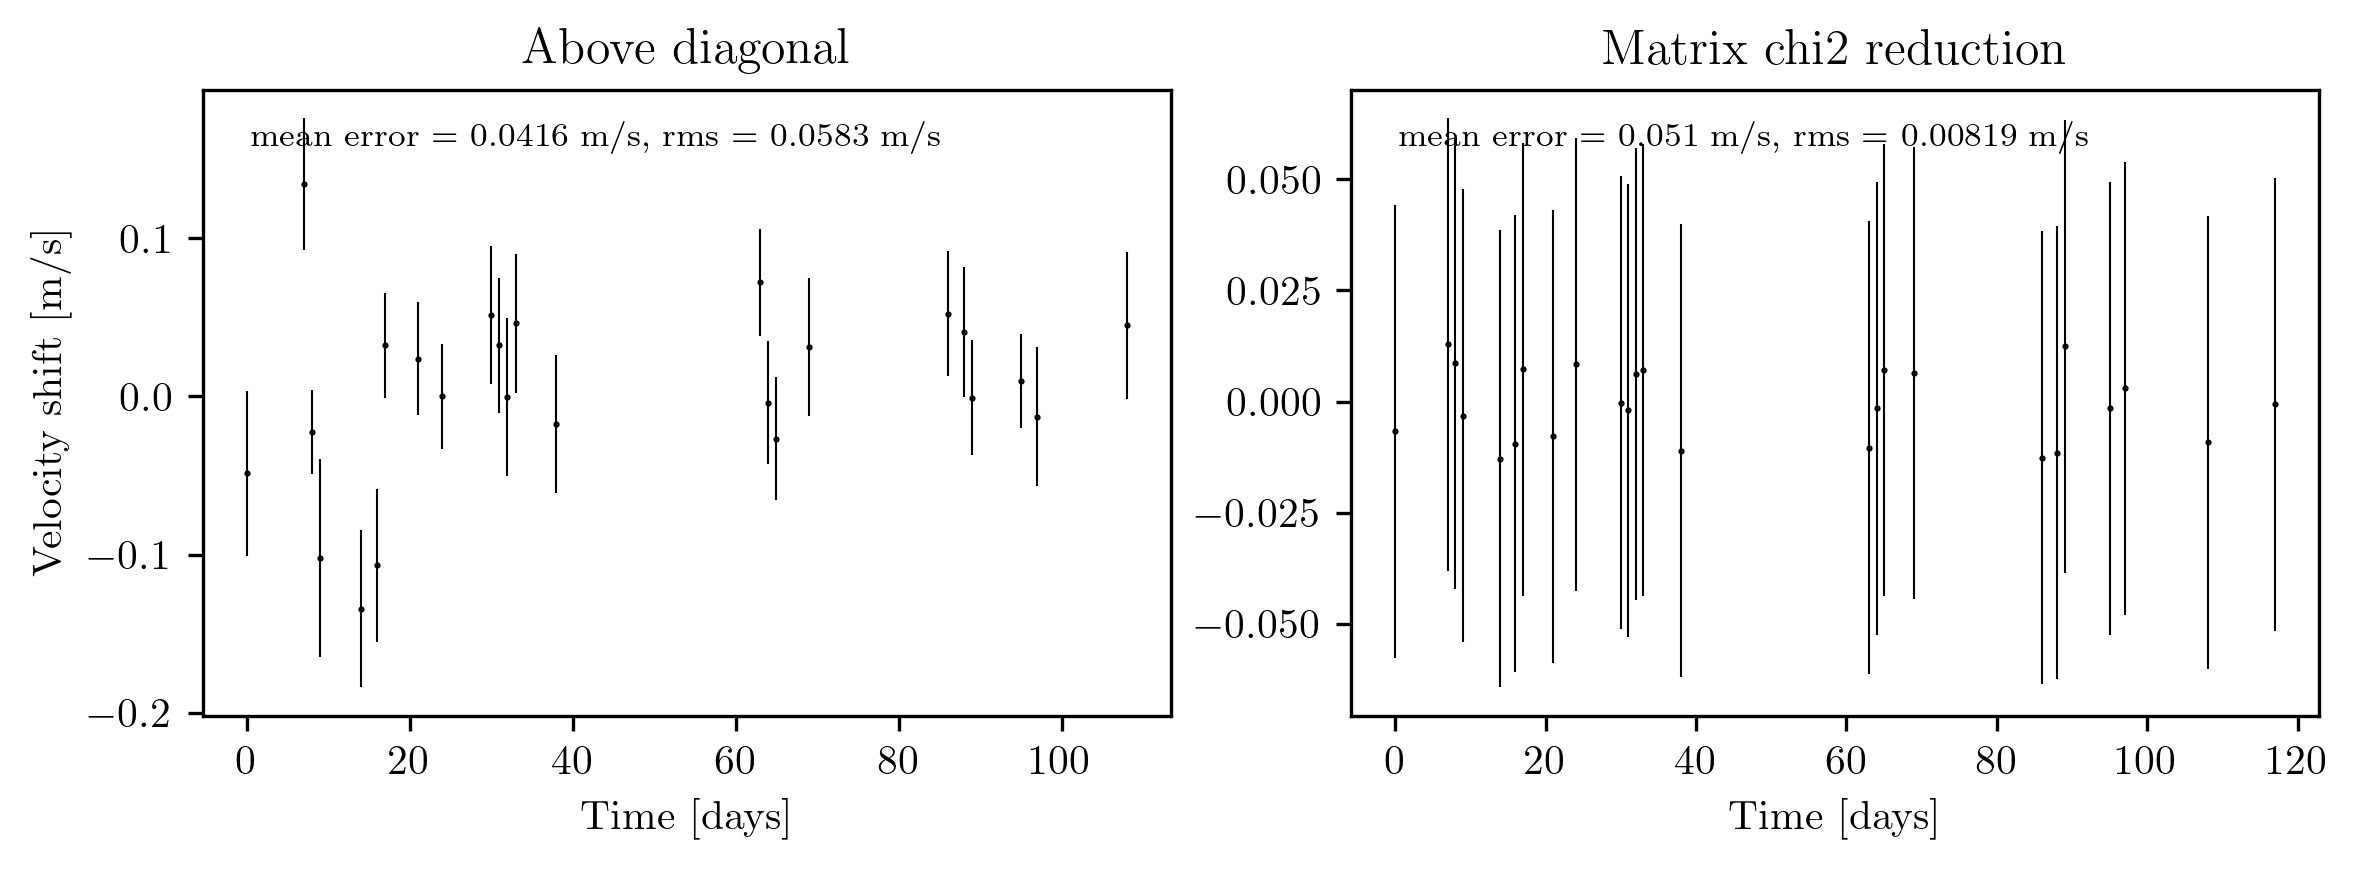

In [326]:
file = RV_RESULTS_PATH + "flipper.npy"
result, coords = np.load(file, allow_pickle=True)
filter_result = remove_outliers_from_result_with_chauvenet(result)
matrix = parse_matrix_results(filter_result, coords, median_err=True)
plot_matrix(*matrix, plot_ratio=False, kms=False)
m, final_shifts, final_shifts_err, days = matrix_reduce(*matrix, SPECTRA_PATH_34411, plot=True)

In [215]:

def beregn(k):

    # k = 30
    f1, f2 = matches[k][0], matches[k][1]

    x1, y1, y1_err, peak1, *_ = f1
    x2, y2, y2_err, peak2, *_ = f2
    print("1000  ::", compute_feature_shift(x1, y1, y1_err, peak1, x2, y2, peak2))

    x1, y1, y1_err, peak1, *_ = f2
    x2, y2, y2_err, peak2, *_ = f1
    print("1000r ::", compute_feature_shift(x1, y1, y1_err, peak1, x2, y2, peak2))

    x1, y1, y1_err, peak1, *_ = f1
    x2, y2, y2_err, peak2, *_ = f2
    print("30    ::", compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2))

    x1, y1, y1_err, peak1, *_ = f2
    x2, y2, y2_err, peak2, *_ = f1
    print("30r   ::", compute_feature_shift2(x1, y1, y1_err, peak1, x2, y2, peak2))


In [263]:
beregn(19)

1000  :: (-91.02766302548116, 7.120777587206248, True)
1000r :: (90.89660194776297, 7.282220577634689, True)
30    :: (-94.7857306601727, 41.99811700428654, True)
30r   :: (104.3027278219397, 45.74768521068199, True)


In [ ]:
# 1000 
(-20.072774213817866, 7.8940607451472715, True)

# 1000 reversed
(20.16833872312054, 8.04098211551991, True)

# 30
(-38.098933854906136, 44.609381595274044, True)

# 30 reversed 
(33.5709485867319, 46.45797863986627, True)



### Errors